# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

print('Setup complete')

Setup complete


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        seed=34)

Found 7591 validated image filenames.


Данных для задачии регрессии может быть не достаточно. Что бы увеличить кол-во фотографий мы можем применить аугментацию.

In [3]:
def get_info(df):
    display(df.head(), df.info(), df.describe().T)
    print('Процент пропусков:\n', df.isna().mean().sort_values(ascending=False)*100)
    print()
    print('Кол-во дубликатов:', df.duplicated().sum())

get_info(labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


None

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Процент пропусков:
 file_name    0.0
real_age     0.0
dtype: float64

Кол-во дубликатов: 0


После предварительного просмотра данных можем сказать что медиана возраста равна 29 лет, среднее 31,2.   
Есть так же фотографии годовалых детей и столетних долгожителей.   
Посмотрим на гисторграмму.

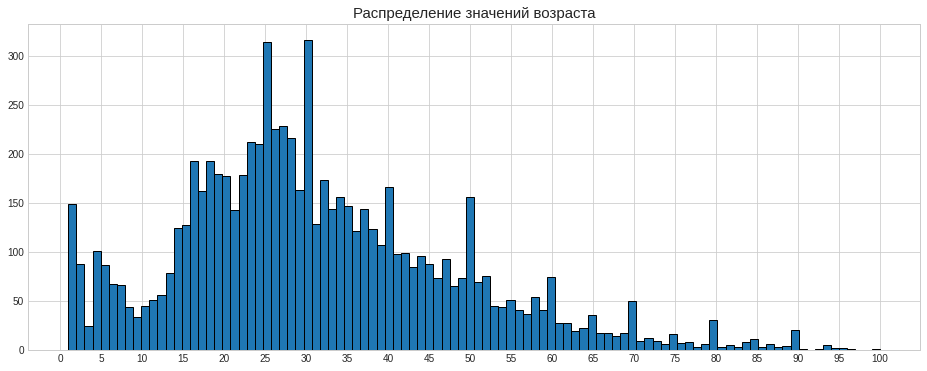

In [4]:
labels['real_age'].hist(bins=100, figsize=(16,6), ec='black')
plt.title('Распределение значений возраста', fontsize=15)
plt.xticks(range(0,105,5));

Распределение нормальное и скошено вправо. Есть некоторые всплески на значениях кратных 10 ничиная с 30 лет, возможно это было округлением или возраст был указан приблизительно. Так же видно большое кол-во детей 2-3 года.   
Посмотрим на boxplot

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


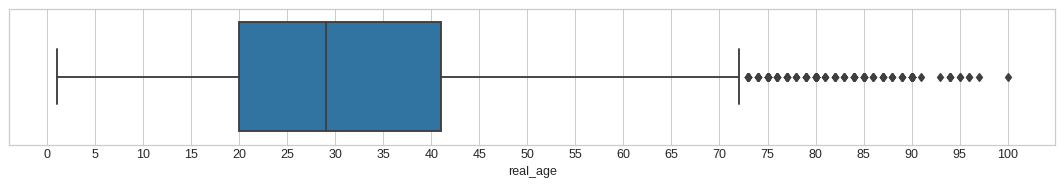

In [5]:
plt.figure(figsize=(15,2), dpi=90)
sns.boxplot(labels['real_age'])
plt.xticks(range(0,105,5));

Основная часть фотографи это возраст 20 - 40 лет, точность определения этих возрастов может быть выше.

In [9]:
features, target = next(gen_flow)

In [10]:
features.shape

(32, 256, 256, 3)

В каждом батче у нас 32 фотографии размером 256х256 и 3 канала на каждую фотографию.   
Посмотрим на 8 фотографий и возраст на них

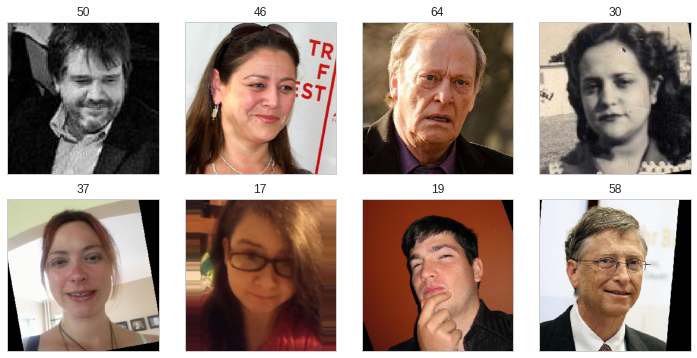

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

Как удачно, даже фото Билла Гейтса у нас есть. На фото ему 58 лет, следовательно фотография сделана 8 лет назад.   
В выборке есть чёрно-белые и искажённые фото. Некоторые фото уже повёрнуты, имеются украшения и аксессуары.    
Для этой задачи выберем сеть ResNet50, аугментацию в нашем случае делать не будем. Из всех возможных видов аугментации больше всего подходит горизонтальное отражение фотографий.

## Обучение модели

**Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке**

```python
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    labels = pd.read_csv(path+'labels.csv')
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=32)

    return train_gen_flow


def load_test(path):
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    labels = pd.read_csv(path + 'labels.csv')
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=32)

    return test_gen_flow

def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    train_datagen_flow = train_data
    val_datagen_flow = test_data
    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 46s - loss: 241.5876 - mae: 11.0642 - val_loss: 911.2710 - val_mae: 25.3539
Epoch 2/10
178/178 - 39s - loss: 61.9301 - mae: 5.9750 - val_loss: 561.3313 - val_mae: 18.2796
Epoch 3/10
178/178 - 39s - loss: 31.2954 - mae: 4.2766 - val_loss: 271.0220 - val_mae: 12.1291
Epoch 4/10
178/178 - 39s - loss: 21.6071 - mae: 3.5799 - val_loss: 164.9105 - val_mae: 10.3434
Epoch 5/10
178/178 - 39s - loss: 16.2631 - mae: 3.0714 - val_loss: 86.2296 - val_mae: 7.1523
Epoch 6/10
178/178 - 38s - loss: 13.4003 - mae: 2.8408 - val_loss: 74.8887 - val_mae: 6.5256
Epoch 7/10
178/178 - 39s - loss: 12.6830 - mae: 2.7543 - val_loss: 65.0666 - val_mae: 6.1617
Epoch 8/10
178/178 - 39s - loss: 10.3540 - mae: 2.4799 - val_loss: 70.1723 - val_mae: 6.4325
Epoch 9/10
178/178 - 39s - loss: 8.6405 - mae: 2.2488 - val_loss: 65.3669 - val_mae: 6.1063
Epoch 10/10
178/178 - 39s - loss: 7.6187 - mae: 2.0783 - val_loss: 62.5966 - val_mae: 5.9581
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 62.5966 - mae: 5.9581
Test MAE: 5.9581

```

## Анализ обученной модели

Наша модель получила не плохие результаты: в среднем она ошибается на **5,96 года** - показатель **MAE**. Использовались предобученные веса `ImageNet`, которые уже были загружены на сервер. **Можно так же заметить что за 10 эпох модель переобучалась.** Посмотрим отвечает ли наша модель на первоначальные запросы бизнеса:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы

Здесь можно использовать данную модель, ошибка в 5,9 года не будет столь критичной.

- Контролировать добросовестность кассиров при продаже алкоголя

Для данной задачи модель не подходит, так как ошибка в 5,9 года может быть критической. Для достижения данной задачи потребуется решение задачи классификации, разделив всю выборку на два класса: менее 18 лет и более 18 лет.